In [1]:
###hdf file package
from pyhdf.SD  import SD, SDC
from pyhdf.V import *
from pyhdf.HDF import * 
###
import pprint
import numpy as np
import math as ma
import pandas as pd
import pickle
### self-defined function
from satellite_read_tool import HDFvars, rFilter
###drawing package
import os
os.environ['PROJ_LIB'] = 'D:\\program\\anaconda3\\Library\\share\\'
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap

In [2]:
###
# 2B-GEOPROF
geoprof_file = '2015270041746_50083_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf'
# ECMWF-AUX
ec_file = '2015270041746_50083_CS_ECMWF-AUX_GRANULE_P_R04_E06.hdf'
# 2B-FLXHR
flx_file = '2015270041746_50083_CS_2B-FLXHR_GRANULE_P2_R04_E06.hdf'
###

In [3]:
## get each hdf file's geolocation info
## CloudSat's geolocation info should be in the vdata
reading_vdata = HDF(geoprof_file, HC.READ).vstart()
vdata =reading_vdata.vdatainfo()
pprint.pprint(vdata[:]) # print vdata info

[('Profile_time', '', 7, 20679, 1, 0, 4, 1962, 0),
 ('UTC_start', '', 8, 1, 1, 0, 4, 1962, 0),
 ('TAI_start', '', 9, 1, 1, 0, 8, 1962, 0),
 ('Latitude', '', 10, 20679, 1, 0, 4, 1962, 0),
 ('Longitude', '', 11, 20679, 1, 0, 4, 1962, 0),
 ('Range_to_intercept', '', 13, 20679, 1, 0, 4, 1962, 0),
 ('DEM_elevation', '', 14, 20679, 1, 0, 2, 1962, 0),
 ('Vertical_binsize', '', 15, 1, 1, 0, 4, 1962, 0),
 ('Pitch_offset', '', 16, 1, 1, 0, 4, 1962, 0),
 ('Roll_offset', '', 17, 1, 1, 0, 4, 1962, 0),
 ('Data_quality', '', 18, 20679, 1, 0, 1, 1962, 0),
 ('Data_status', '', 19, 20679, 1, 0, 1, 1962, 0),
 ('Data_targetID', '', 20, 20679, 1, 0, 1, 1962, 0),
 ('SurfaceHeightBin', '', 21, 20679, 1, 0, 1, 1962, 0),
 ('SurfaceHeightBin_fraction', '', 22, 20679, 1, 0, 4, 1962, 0),
 ('Sigma-Zero', '', 29, 20679, 1, 0, 2, 1962, 0),
 ('MODIS_cloud_flag', '', 30, 20679, 1, 0, 1, 1962, 0),
 ('MODIS_Cloud_Fraction', '', 31, 20679, 1, 0, 1, 1962, 0),
 ('MODIS_scene_char', '', 32, 20679, 1, 0, 1, 1962, 0),
 ('MODI

In [4]:
### load vdata variables
## longitude, latitude 
## data quality: value<0 means data okay, SurfaceHeightBin: surface height at which bin: [1~125] 
members = [ 10, 11, 18, 21] 
nrecs = []
names = []
for ref in members:
    vd = reading_vdata.attach(ref)
    nrecs.append(vd.inquire()[0])  ## number of records of the Vdata
    names.append(vd.inquire()[-1]) ## name of the Vdata
    vd.detach()
#print(names) ## print variable name
#print(nrecs) ## variable array length

## load data
# longitude
idx = names.index('Longitude',)
var = reading_vdata.attach(members[idx])
longitude = var.read(nrecs[idx])
# latitude
idx = names.index('Latitude',)
var = reading_vdata.attach(members[idx])
latitude = var.read(nrecs[idx])
# data quality
idx = names.index('Data_quality',)
var = reading_vdata.attach(members[idx])
data_quality = var.read(nrecs[idx])
# surface height position 
idx = names.index('SurfaceHeightBin')
var = reading_vdata.attach(members[idx])
Height_bin = var.read(nrecs[idx])

In [29]:
## longitude demo
# CloudSat lon range: -180~180
lon_demo = pd.DataFrame(longitude[:], columns= ['Longitude'])
print(lon_demo.shape)
print(lon_demo.head())
## latitude demo
# CloudSat lat range: -90~90
lat_demo = pd.DataFrame(latitude[:], columns= ['Latitude'])
print(lat_demo.shape)
print(lat_demo.head())

(20679, 1)
    Longitude
0 -166.369415
1 -166.419327
2 -166.469223
3 -166.519119
4 -166.568909
(20679, 1)
    Latitude
0 -80.412704
1 -80.407669
2 -80.402626
3 -80.397583
4 -80.392525


In [30]:
## change the lon range from -180~180 to 0~360
lon = np.array(longitude)
modify_lon = np.where(lon  >= 0, lon , lon +360)

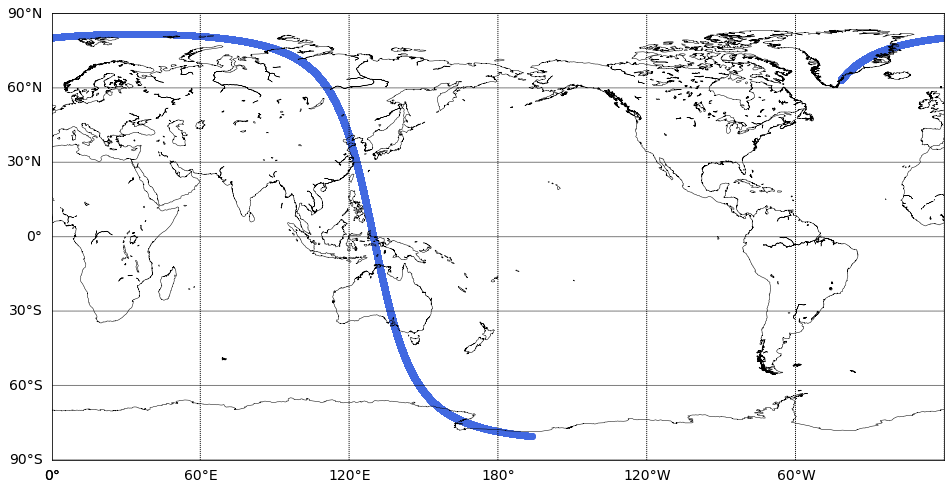

In [31]:
## one CloudSat Swath demo
## only day-time obervation after 2011
fig = plt.figure(figsize=(16,12)) 
m = Basemap(llcrnrlon=0, urcrnrlon=360., llcrnrlat=-90., urcrnrlat=90.,resolution='l')
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0], fontsize=14)
m.drawmeridians(np.arange(-180., 181., 60.), labels=[0, 0, 0, 1], fontsize=14)
m.scatter(modify_lon[:], latitude[:] , c='royalblue')

In [33]:
## study region
## lon: 0~360; lat: 90~-90 (same as era-interim)
real_lon_cen = 125
real_lat_cen = 21
lon_range = 15
lat_range = 5
## latitude & longitude range for regional filter
lon_cloudsat = [real_lon_cen-lon_range,real_lon_cen+lon_range]
lat_cloudsat = [real_lat_cen-lat_range,real_lat_cen+lat_range]

In [34]:
## filtered the CloudSat data
region_mask = rFilter(longitude,latitude,lon_cloudsat,lat_cloudsat)

In [35]:
# list to numpy array
pre_lon = np.array(longitude)
pre_lat = np.array(latitude)
qua = np.array(data_quality)
height_bin = np.array(Height_bin)

In [63]:
### GEOPROF  data load
var_name = HDFvars(geoprof_file) # 2D variable name e.g.var[track_cloumns,125]
print(var_name)
hdfFile = SD(geoprof_file,SDC.READ)

['CPR_Cloud_mask', 'Gaseous_Attenuation', 'Height', 'Radar_Reflectivity']


In [64]:
## load data
# cloud mask
Cloud_mask = hdfFile.select('CPR_Cloud_mask')
cloud_mask = Cloud_mask[:,:]
# reflectivity
Reflectivity = hdfFile.select('Radar_Reflectivity')
reflectivity = Reflectivity[:,:]/100 # divided by factor
# bin hieght
Height = hdfFile.select('Height')
height = Height[:,:]

In [41]:
### ECMWF_AUX data load
var_name = HDFvars(ec_file) # 2D variable name e.g.var[track_cloumns,125]
print(var_name)
hdfFile = SD(ec_file,SDC.READ)

['Extrapolation_flag', 'Ozone', 'Pressure', 'Specific_humidity', 'Temperature']


In [42]:
## load data
# Pressure
Pressure = hdfFile.select('Pressure')
pressure = Pressure[:,:]

In [65]:
### filter process
### all data should be filtered by regional mask & quality mask
## quality mask 
qua_mask = qua[region_mask[:,0]>0]
# longitude 
e_lon = pre_lon[region_mask[:,0]>0,0]
eq_lon = e_lon[qua_mask[:,0]<0.5]
# latitude 
e_lat = pre_lat[region_mask[:,0]>0,0]
eq_lat = e_lat[qua_mask[:,0]<0.5]
# surface height 
e_height_bin = height_bin[region_mask[:,0]>0]
eq_height_bin = e_height_bin[qua_mask[:,0]<0.5]
eq_height_bin = np.where(eq_height_bin >= 0, eq_height_bin, 125) # fill the missing value with 125
# cloud mask
e_cloud_mask = cloud_mask[region_mask[:,0]>0,:]
eq_cloud_mask = e_cloud_mask[qua_mask[:,0]<0.5,:]
# reflectivity
e_ref = reflectivity[region_mask[:,0]>0,:]
eq_ref = e_ref[qua_mask[:,0]<0.5,:]
# height info
e_height = height[region_mask[:,0]>0,:]
eq_height = e_height[qua_mask[:,0]<0.5,:]
## EC pressure
e_pressure = pressure[region_mask[:,0]>0,:]
eq_pressure = e_pressure[qua_mask[:,0]<0.5,:]

In [44]:
### regional data array length
region_array_size = eq_cloud_mask.shape
print(region_array_size[0])

1036


In [45]:
with open('demo_truecolor_rgb_20150927.pkl', 'rb') as f:
         rgb = pickle.load(f)

In [47]:
print('ext shape')
x = np.arange(85.0025,205.0025,0.005)
y = np.arange(-59.9975,60.0025,0.005)
local_lon = x[5800:10200]
local_lat = y[13800:18200]

ext shape


In [48]:
mesh = rgb[:,:-1,:]
color_t = mesh.reshape((mesh.shape[0] * mesh.shape[1]),3)
color_t[color_t>1] = 1

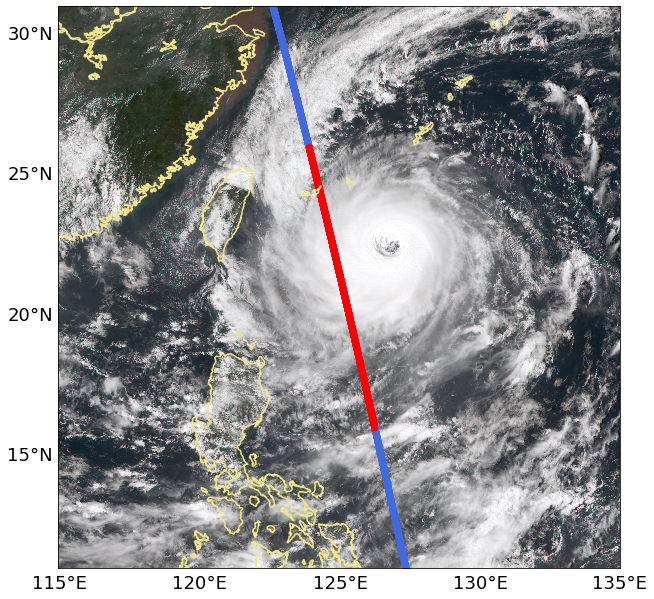

In [29]:
### plot regional swath demo
fig = plt.figure(figsize=(9,9)) 
# lat lon setting
m = Basemap(llcrnrlon=115, urcrnrlon=135, llcrnrlat=11, urcrnrlat=31,resolution='i')
m.drawcoastlines(linewidth=1.5,color='khaki')
m.drawparallels(np.arange(10., 31., 5.), labels=[1, 0, 0, 0], linewidth=0, color='k', fontsize=18)
m.drawmeridians(np.arange(115., 139., 5.), labels=[0, 0, 0, 1], linewidth=0, color='k', fontsize=18)
m.pcolormesh(local_lon,local_lat,rgb[:,:,0],color=color_t)
# draw swath (blue: total swath; red: filtered swath)
m.scatter(pre_lon[:], pre_lat[:] , c='royalblue')
m.scatter(eq_lon[:], eq_lat[:] , c='r')
plt.tight_layout()

In [67]:
## transpose the array then overturn the columns, just for drawing
# cloud mask
t_cloud = eq_cloud_mask[:,:].T
r_cloud = t_cloud[::-1]
# reflectivity
t_ref = eq_ref [:,:].T
r_ref = t_ref[::-1]
# reference height for y axis 
t_hei = eq_height[:,:].T
r_height = t_hei[::-1]
ref_height = np.mean(r_height,axis=1)
# unit: meter --> km
ref_height = np.around(ref_height/1000,decimals=1)
# latitude for x axis
region_lat = np.around(eq_lat,decimals=1)

Text(0.5, 0, 'Latitude')

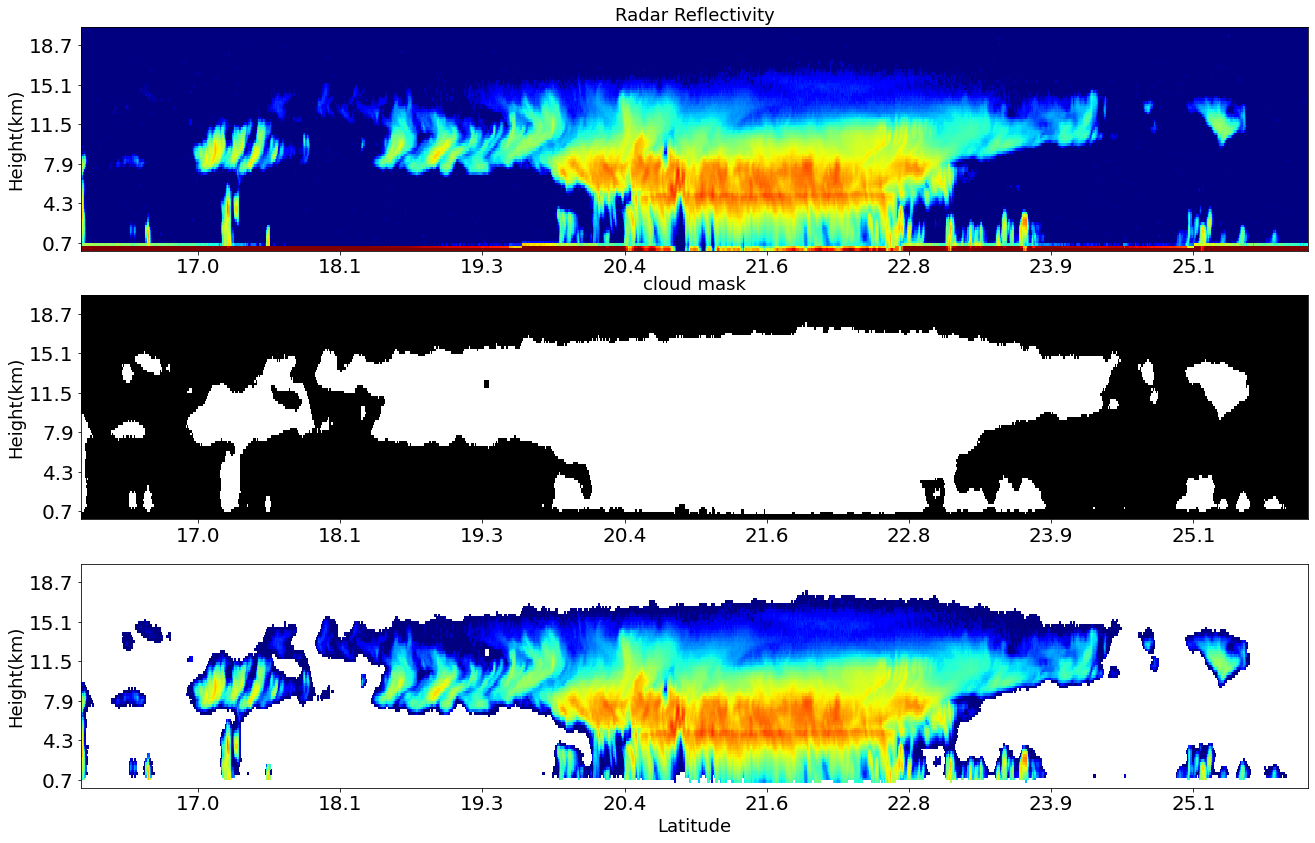

In [317]:
f = plt.figure(figsize=(22,14))
## first figure: reflectivity
axs = f.add_subplot(3,1,1)
plt.pcolormesh(r_ref[20:105,:],cmap=plt.cm.get_cmap('jet',100),vmin=-25, vmax=25)
plt.title('Radar Reflectivity',fontsize=18)
# axis setting
plt.yticks(np.arange(3,90,step=15), (ref_height[23:110:15,]),fontsize=20)
plt.xticks(np.arange(99,region_array_size[0],step=120), (region_lat[99:region_array_size[0]:120,]),fontsize=20)
plt.ylabel('Height(km)',color='k',fontsize=18)

## second figure: cloud mask
axs = f.add_subplot(3,1,2)
masked_cloud = np.where(r_cloud >= 19.5, r_cloud, 0) 
plt.pcolormesh(masked_cloud[20:105,:],cmap=plt.cm.get_cmap('gist_gray',2),vmin=19, vmax=20, alpha=1)
plt.title('cloud mask',fontsize=18)
# axis setting
plt.yticks(np.arange(3,90,step=15), (ref_height[23:110:15,]),fontsize=20)
plt.xticks(np.arange(99,region_array_size[0],step=120), (region_lat[99:region_array_size[0]:120,]),fontsize=20)
plt.ylabel('Height(km)',color='k',fontsize=18)

## third figure: reflectivity filtered by cloud mask
axs = f.add_subplot(3,1,3)
ref_masked = np.ma.masked_where(masked_cloud < 19.5 , r_ref)
plt.pcolormesh(ref_masked[20:105,:],cmap=plt.cm.get_cmap('jet',100),vmin=-25, vmax=25)
#plt.pcolormesh(masked_cloud[20:105,:],cmap=plt.cm.get_cmap('gist_gray',100),vmin=5,vmax=19,alpha=0.2)
# axis setting
plt.yticks(np.arange(3,90,step=15), (ref_height[23:110:15,]),fontsize=20)
plt.xticks(np.arange(99,region_array_size[0],step=120), (region_lat[99:region_array_size[0]:120,]),fontsize=20)
plt.ylabel('Height(km)',color='k',fontsize=18)
plt.xlabel('Latitude',color='k',fontsize=18)

In [276]:
## transpose the array then overturn the columns
# reference pressure for y axis 
t_pressure = eq_pressure[:,:].T
r_pressure = t_pressure[::-1]
# unit: Pa --> hPa
ref_pressure = np.mean(r_pressure,axis=1)/100
ref_pressure = np.around(ref_pressure,decimals=0)

Text(0.5, 0, 'Latitude')

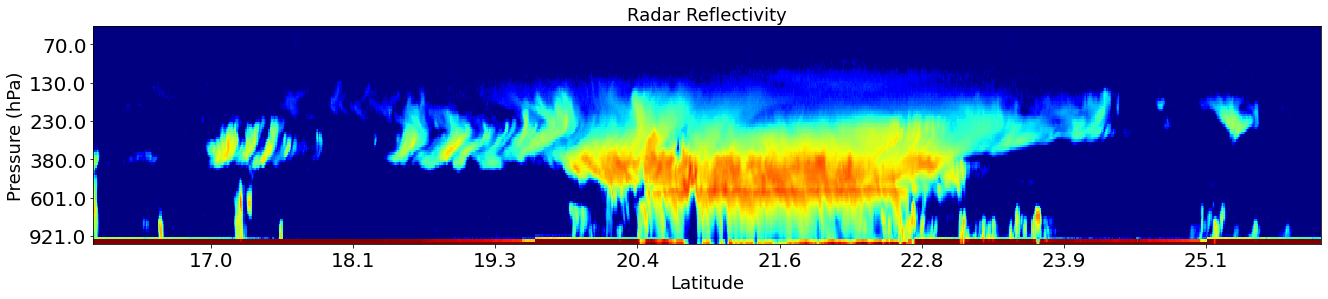

In [277]:
f = plt.figure(figsize=(22,4))
# figure: height axis --> pressure axis
plt.pcolormesh(r_ref[20:105,:],cmap=plt.cm.get_cmap('jet',100),vmin=-25, vmax=25)
plt.title('Radar Reflectivity',fontsize=18)
# axis setting
plt.yticks(np.arange(3,90,step=15), (ref_pressure[23:110:15,]),fontsize=20)
plt.xticks(np.arange(99,region_array_size[0],step=120), (region_lat[99:region_array_size[0]:120,]),fontsize=20)
plt.ylabel('Pressure (hPa)',color='k',fontsize=18)
plt.xlabel('Latitude',color='k',fontsize=18)

In [75]:
## get each hdf file's geolocation info
## CloudSat's geolocation info should be in the vdata
reading_vdata = HDF(flx_file, HC.READ).vstart()
vdata =reading_vdata.vdatainfo()
print(vdata[10]) # 
print(vdata[11]) # data status check if the column have liquid water, ice or rain


('Data_quality', '', 18, 20679, 1, 0, 1, 1962, 0)
('Data_status', '', 19, 20679, 1, 0, 1, 1962, 0)


In [76]:
members = [18, 19] 
nrecs = []
names = []
for ref in members:
    vd = reading_vdata.attach(ref)
    nrecs.append(vd.inquire()[0])  ## number of records of the Vdata
    names.append(vd.inquire()[-1]) ## name of the Vdata
    vd.detach()
#print(names) ## print variable name
#print(nrecs) ## variable array length

## load data
# data quality
idx = names.index('Data_quality',)
var = reading_vdata.attach(members[idx])
data_quality = var.read(nrecs[idx])
qua = np.array(data_quality)

In [136]:
var_name = HDFvars(flx_file) # 2D variable name e.g.var[track_cloumns,125]
print(var_name)
hdfFile = SD(flx_file,SDC.READ)

['BOACRE', 'BinCounts', 'FD', 'FD_NC', 'FU', 'FU_NC', 'Height', 'MeanOLR', 'MeanOSR', 'MeanQLW', 'MeanQSW', 'MeanSFCE', 'MeanSFCR', 'MeanSLR', 'MeanSSR', 'Meansolar', 'QR', 'RH', 'SigmaOLR', 'SigmaOSR', 'SigmaQLW', 'SigmaQSW', 'SigmaSFCE', 'SigmaSFCR', 'SigmaSLR', 'SigmaSSR', 'Sigmasolar', 'TOACRE']


In [139]:
## load data
#QR: total heating rate
QR = hdfFile.select('QR')
qr = QR[:,:,:]
qr = np.ma.masked_where(qr>31171,qr) # maskout the filled value of QR
qr = qr/100 # divided by factor
print(qr.shape)
# BOA & TOA cloud radiative effect
BOAA = hdfFile.select('BOACRE')
TOAA = hdfFile.select('TOACRE')
BOA = BOAA[:,:]
TOA = TOAA[:,:]
BOA = np.ma.masked_where(BOA<-998,BOA) # maskout the filled value of BOA
TOA = np.ma.masked_where(TOA<-998,TOA) # maskout the filled value of TOA
print(BOA.shape)

(2, 20679, 125)
(2, 20679)


In [140]:
### filter process
### all data should be filtered by regional mask & quality mask
## quality mask 
qua_mask = qua[region_mask[:,0]>0]
# QR
e_qr = qr[:,region_mask[:,0]>0,:]
eq_qr = e_qr[:,qua_mask[:,0]<0.5,:]
# BOA & TOA CRE
e_boa = BOA[:,region_mask[:,0]>0]
eq_boa = e_boa[:,qua_mask[:,0]<0.5]
e_toa = TOA[:,region_mask[:,0]>0]
eq_toa = e_toa[:,qua_mask[:,0]<0.5]

In [141]:
short_qr = eq_qr[0,:,:] # shortwave heating rate
long_qr = eq_qr[1,:,:]  # longwave heating rate
## transpose the array then overturn the columns, just for drawing
t_long_qr = long_qr[:,:].T
r_long_qr = t_long_qr[::-1]   
t_short_qr = short_qr[:,:].T
r_short_qr = t_short_qr[::-1] 

Text(0.5, 0, 'Latitude')

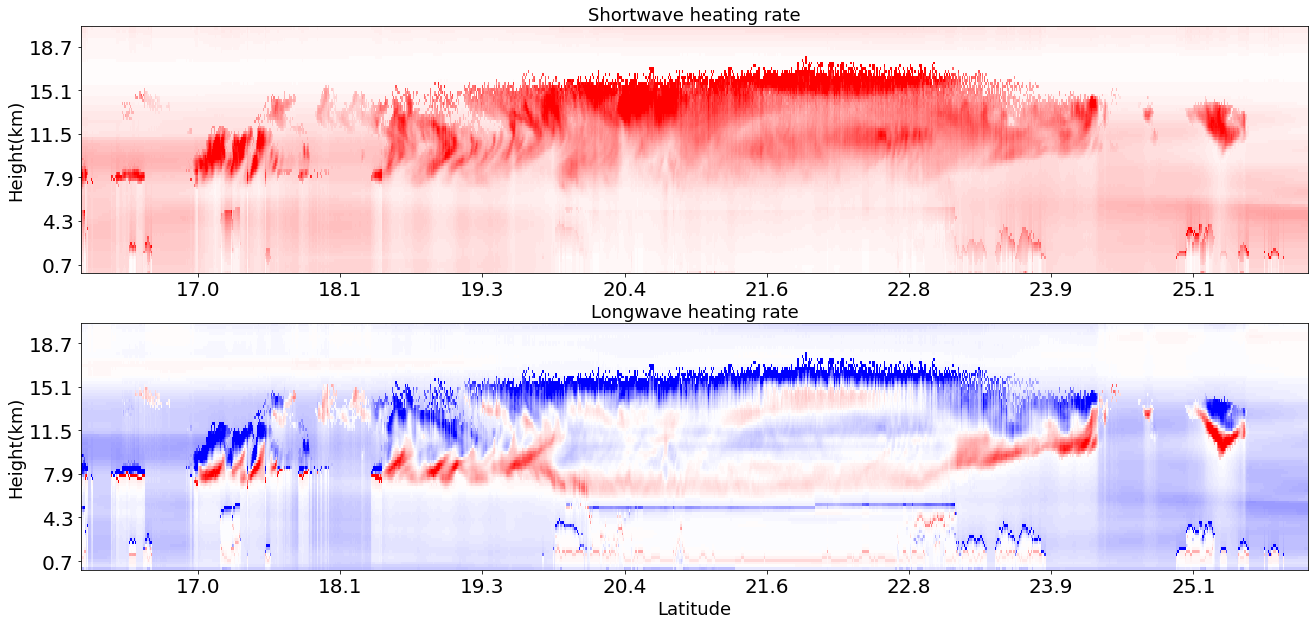

In [142]:
f = plt.figure(figsize=(22,10))
## first figure: shortwave heating rate (red:heating; blue cooling)
axs = f.add_subplot(2,1,1)
plt.pcolormesh(r_short_qr[20:105,:],cmap=plt.cm.get_cmap('bwr',100),vmin=-10, vmax=10)
plt.title('Shortwave heating rate',fontsize=18)
# axis setting
plt.yticks(np.arange(3,90,step=15), (ref_height[23:110:15,]),fontsize=20)
plt.xticks(np.arange(99,region_array_size[0],step=120), (region_lat[99:region_array_size[0]:120,]),fontsize=20)
plt.ylabel('Height(km)',color='k',fontsize=18)

## second figure: longwave heating rate (red:heating; blue cooling)
axs = f.add_subplot(2,1,2)
plt.pcolormesh(r_long_qr[20:105,:],cmap=plt.cm.get_cmap('bwr',100),vmin=-10, vmax=10)
plt.title('Longwave heating rate',fontsize=18)
# axis setting
plt.yticks(np.arange(3,90,step=15), (ref_height[23:110:15,]),fontsize=20)
plt.xticks(np.arange(99,region_array_size[0],step=120), (region_lat[99:region_array_size[0]:120,]),fontsize=20)
plt.ylabel('Height(km)',color='k',fontsize=18)
plt.xlabel('Latitude',color='k',fontsize=18)
#plt.colorbar(fraction=0.07,aspect=30,pad=0.2,orientation='horizontal')

Text(0.5, 0, 'Latitude')

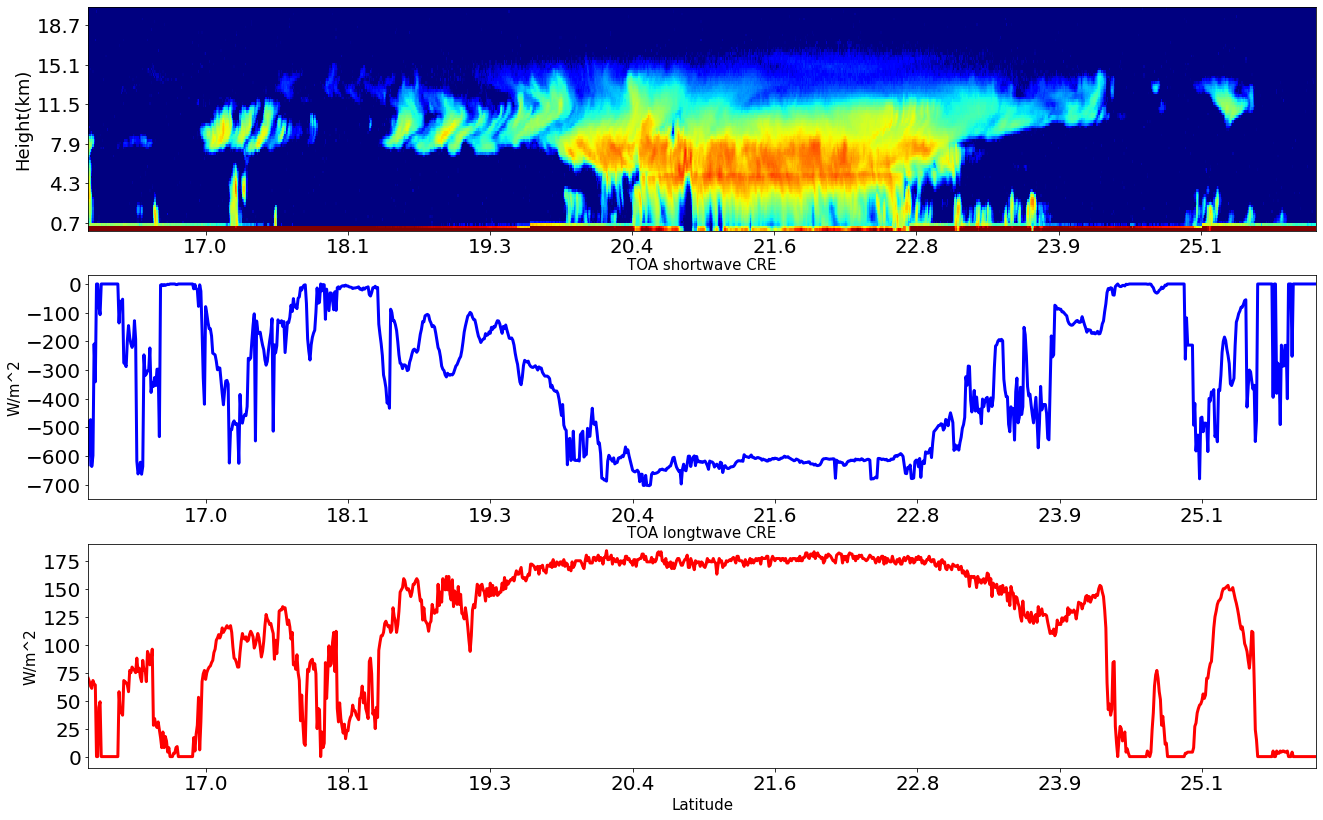

In [144]:
f= plt.figure(figsize=(22,14))
## first figure: reflectivity
axs = f.add_subplot(3,1,1)
plt.pcolormesh(r_ref[20:105,:],cmap=plt.cm.get_cmap('jet',100),vmin=-25, vmax=25)
# axis setting
plt.yticks(np.arange(3,90,step=15), (ref_height[23:110:15,]),fontsize=20)
plt.xticks(np.arange(99,region_array_size[0],step=120), (region_lat[99:region_array_size[0]:120,]),fontsize=20)
plt.ylabel('Height(km)',color='k',fontsize=18)

## second figure: TOA shortwave CRE
axs = f.add_subplot(3,1,2)
plt.plot(eq_toa[0,:],linewidth=3,color='b')
plt.title('TOA shortwave CRE',fontsize=15)
# axis setting
plt.axis([0,1035,-750,30])
plt.yticks(fontsize=20)
plt.xticks(np.arange(99,region_array_size[0],step=120), (region_lat[99:region_array_size[0]:120,]),fontsize=20)
plt.ylabel('W/m^2',color='k',fontsize=15)

## third figure: TOA longwave CRE
axs = f.add_subplot(3,1,3)
plt.plot(eq_toa[1,:],linewidth=3,color='r')
plt.title('TOA longtwave CRE',fontsize=15)
# axis setting
plt.axis([0,1035,-10,190])
plt.yticks(fontsize=20)
plt.xticks(np.arange(99,region_array_size[0],step=120), (region_lat[99:region_array_size[0]:120,]),fontsize=20)
plt.ylabel('W/m^2',color='k',fontsize=15)
plt.xlabel('Latitude',color='k',fontsize=15)

In [331]:
#### homework demo
### cloud frequency: cloud pixels/total pixels
### regrid process 1: x-axis, regrid to 0.5 degree latitude resolution
## latitude grid length: lat range/latitude grid resolution
grid_resolution=0.5
y_len=int((lat_range*2/grid_resolution))
## regional data length filtered by regional mask & quality mask
mask_len = len(eq_lat)
lat_mask = np.zeros((mask_len,1))
y_mask = abs((eq_lat[:]-16)/grid_resolution)

In [332]:
## pix array store total effective pixels that CloudSat observed
## cld array store total effective "cloud" pixels that CloudSat observed
to_pix = np.zeros((125,y_len))
to_cld = np.zeros((125,y_len))
to_pressure = np.zeros((125,y_len))
for kkk in range(0,mask_len):
## mask for re-grid
    lat_mask[kkk,0] = ma.ceil(y_mask[kkk])-1 ## latitude
## calculate total pixels & cloud pixels
    for h in range(0,int(eq_height_bin[kkk])):
        to_pix[h,int(lat_mask[kkk,0])]=to_pix[h,int(lat_mask[kkk,0])]+1
        if eq_cloud_mask[kkk,h]>19:
            to_cld[h,int(lat_mask[kkk,0])]=to_cld[h,int(lat_mask[kkk,0])]+1
### regrid process 2 - regrid to ec pressure level
## calculate regrided grid reference pressure
    for yy in range(0,y_len):
        lat_pressure = eq_pressure[lat_mask[:,0]==yy,:]
        y_masked = np.ma.masked_where(lat_pressure < 0 , lat_pressure)
        mean_pressure = np.mean(y_masked,axis=0)
        to_pressure[:,yy] = mean_pressure

In [321]:
## for ec var z axis
lev = [1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 700, 650, 600, 550, 500, 450, 400, 350, 300, 250, 225, 200, 175, 150, 125, 100, 70, 50, 30, 20, 10, 7, 5, 3, 2, 1]
## for cloudsat z axis
lev_r = [1,2,3,5,7,10,20,30,50,70,100,125,150,175,200,225,250,300,350,400,450,500,550,600,650,700,750,775,800,825,850,875,900,925,950,975,1100]
cl_lev = np.array(lev_r)*100

In [219]:
## creating regrid process completed array to store results
demo_pix = np.zeros((37,y_len))
demo_cld = np.zeros((37,y_len))

In [221]:
## regrid to ec pressure level
for k in range(0,y_len):
    for h in range (0,125):
        for hh in range(4,36):
            if to_pressure[h,k] <= cl_lev[hh+1] and to_pressure[h,k] > cl_lev[hh]:
                demo_pix[hh+1,k] = demo_pix[hh+1,k]+to_pix[h,k]
                demo_cld[hh+1,k] = demo_cld[hh+1,k]+to_cld[h,k]

In [234]:
## claculate cloud frequency
demo_pix[demo_pix==0]=1
cf = (demo_cld[:,:]/demo_pix[:,:])*100

In [240]:
### color map for cloud frequency
cmap1 = mpl.cm.jet(np.linspace(0,1,24))
cmap2 = mpl.cm.nipy_spectral(np.linspace(0,1,24))
self_cmap = np.vstack((cmap1[0],cmap1[2],cmap1[5],cmap1[8],cmap2[13],cmap2[15],cmap1[15],cmap1[17],cmap1[19],cmap1[22]))
cmap = mpl.colors.ListedColormap(self_cmap)
###

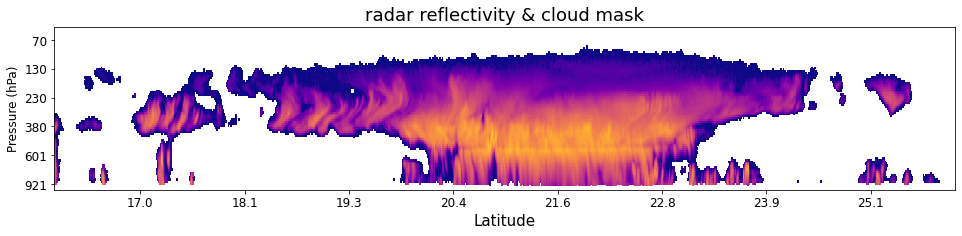

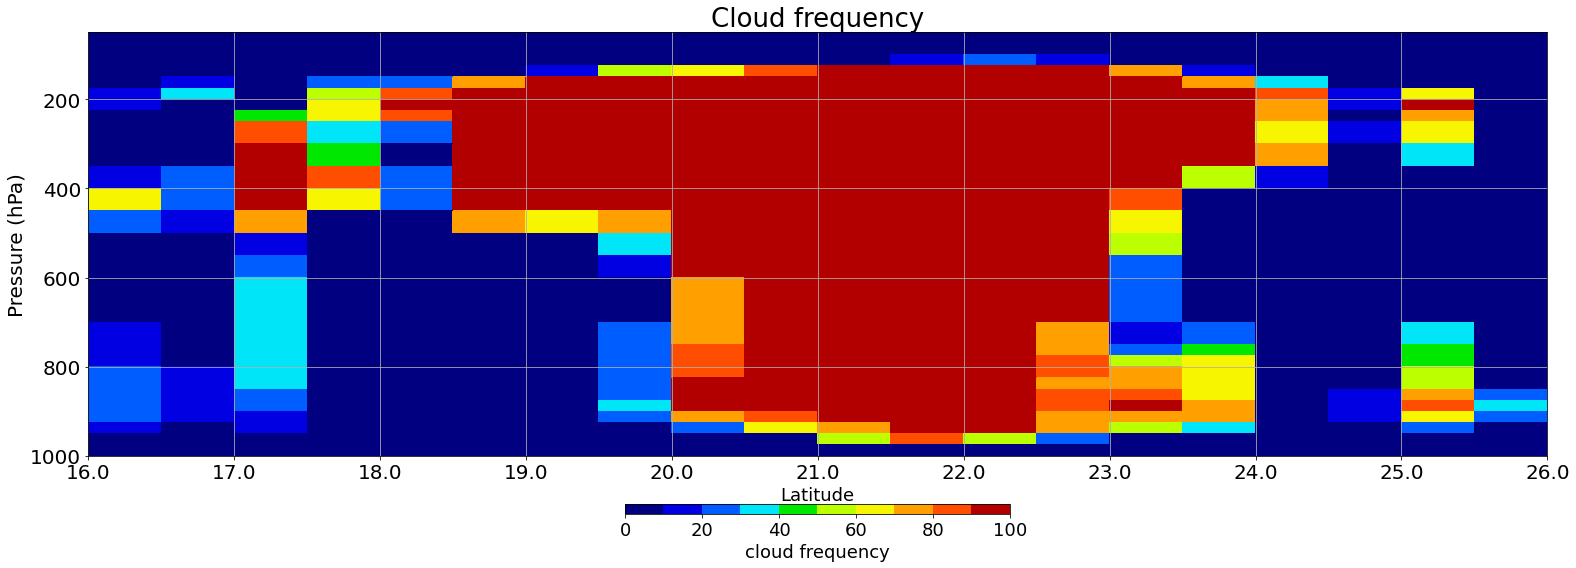

In [328]:
## first figure: reflectivity filtered by cloud mask
f = plt.figure(figsize=(16.15,3))
plt.pcolormesh(ref_masked[20:105,:],cmap=plt.cm.get_cmap('plasma',100),vmin=-25, vmax=25)
plt.title('radar reflectivity & cloud mask',fontsize=18)
# axis setting
plt_pressure = ref_pressure.astype(int)
plt.yticks(np.arange(3,90,step=15), (plt_pressure[23:110:15,]),fontsize=12)
plt.xticks(np.arange(99,region_array_size[0],step=120), (region_lat[99:region_array_size[0]:120,]),fontsize=12)
plt.ylabel('Pressure (hPa)',color='k',fontsize=12)
plt.xlabel('Latitude',color='k',fontsize=15)

## second figure: cloud frequency regrid to ec pressure level
f = plt.figure(figsize=(22,8))
x = np.arange(0,20.1,1)
plt.pcolormesh(x,lev_r[5:37],cf[5:37,:], cmap=cmap,vmin=0,vmax=100)
# colorbar setting
cb = plt.colorbar(aspect=40,fraction=0.02, pad=0.1, orientation='horizontal',extendfrac='auto')
cb.ax.tick_params(labelsize=18)
cb.set_label('cloud frequency', size=18)
# axis setting
plt.axis([0,20,1000,50])
plt.grid()
ax = np.arange(real_lat_cen-lat_range,real_lat_cen+lat_range+0.1,grid_resolution*2)
xx = np.arange(0,20.1,2)
plt.xticks(xx,ax,fontsize=20)
plt.yticks(fontsize=20)
## title & label
plt.title('Cloud frequency',fontsize=26)
plt.xlabel('Latitude',fontsize=18)
plt.ylabel('Pressure (hPa)',fontsize=20)
plt.tight_layout()